In [97]:
include("../src/QuantumEvolution.jl")
using LaTeXStrings
using PyPlot

In [28]:
q = FockBasis(5) # osc(5, "Transmon");
r = FockBasis(30) # osc(30, "Resonator");
s = q ⊗ r
init = dm(fockstate(q, 0) ⊗ fockstate(r, 0))

Iq = identityoperator(q)
Ir = identityoperator(r)
a = Iq ⊗ destroy(r);

qel(i,j) = projector(fockstate(q, i), fockstate(q, j)') ⊗ Ir
n = a' * a;

In [29]:
# Bare parameters
ωq = (2π)*5.93             # qubit frequency (GHz): energy gap between |0⟩ and |1⟩ levels
ωr = (2π)*6.626            # resonator frequency (GHz), detuned from the qubit frequency in dispersive regime
η  = (2π)*0.216            # qubit anharmonicity  (GHz)
g  = (2π)*0.128            # qubit-resonator coupling strength (GHz)
ωd = ωr                    # microwave drive frequency
κ  = (2π)/69               # resonator decay rate

# Compute effective frequency shifts
χ  = -η*g^2 / (ωq - ωr)^2  # resonator dispersive frequency shift: 2χ is net change in ωq
λ  = -g^2 / (ωq - ωr)      # Lamb shift of resonator frequency
ωreff = ωr + λ + χ         # effective (ground-state) resonator frequency including Lamb and dispersive shift

# Set pump strength
nmax = 4                   # target photon number at steady state
ɛ  = sqrt(nmax*((ωreff-ωd)^2 + (κ/2)^2))  # microwave drive amplitude;

In [30]:
# Hamiltonian
#  Qubit free evolution
Hq = sum((k*(ωq - ωd) - k*(k+1)*η/2)*qel(k,k) for k in 0:(length(q)-1))
#  Resonator free evolution
Hr = (ωr - ωd)* n
#  Microwave pump
Hp = ɛ * (a .+ a')
#  Qubit-resonator interaction (Jaynes-Cummings-type interaction)
Hint = sum((sqrt(k)*g)*(a * qel(k,k-1) + a' * qel(k-1,k)) for k in 1:(length(q)-1));
#   Total Hamiltonian
H = Hq + Hr + Hp + Hint;

# Dissipative collapse operator (Lindblad Markovian decay)
Lr = sqrt(κ/2)*a;

In [60]:
function solveρ(step, Δt=0.1)
    meana(ρ) = expect(ρ, a)
    pop(ρ) = real(expect(ρ, n))
    p0(ρ) = real(expect(ρ, qel(0,0)))
    p1(ρ) = real(expect(ρ, qel(1,1)))
    p2(ρ) = real(expect(ρ, qel(2,2)))
    t = trajectory(step(Δt, H, clist=[Lr]), init, (0.0, 200.0), meana, pop, p0, p1, p2, dt=Δt)
end;
function plotsolution(t)
    as = t[1]
    ns = t[2]
    p0s = t[3]
    p1s = t[4]
    p2s = t[5]
    
    figure(1)
    p1 = plot(real(as), imag(as), label=L"$\alpha(t)$")
    ax = gca()
    ax.set_ylim([-2.1,2.1])
    ax.set_xlim([-4.5,0.5])
    xlabel(L"Re$\alpha$")
    ylabel(L"Im$\alpha$")
    title("Classical Resonator amplitude")
    legend()
    grid()
    show()
    
    figure(2)
    p2 = plot(ns.t, ns)
    xlabel(L"$t$ (ns)")
    ylabel(L"$n(t)$")
    title("Photon Number vs. Time")
    grid()
    show()

    figure(3)
    ax = gca()
    ax.set_ylim([0,1.05])
    p2 = plot(p0s.t, p0s, label=L"$P_0$")
    plot(p1s.t, p1s, label=L"$P_1$")
    plot(p2s.t, p2s, label=L"$P_2$")
    plot(p0s.t, p0s.+p1s.+p2s, label=L"$P_{\rm tot}$")
    xlabel(L"$t$ (ns)")
    ylabel("Probability")
    title("Qubit Populations vs. Time")
    grid()
    legend()
    show()
end;

┌ Info: Trajectory: steps = 
│   N - 1 = 2000
│   , points =  = , points = 
│   Ns = 1000
│   , values =  = , values = 
│   Nf = 5
└ @ Main /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QEvolution.jl:437
┌ Info: Time elapsed: 
│   elapsed = 65.23539090156555
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 30.658205191378766
└ @ Main /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QEvolution.jl:455


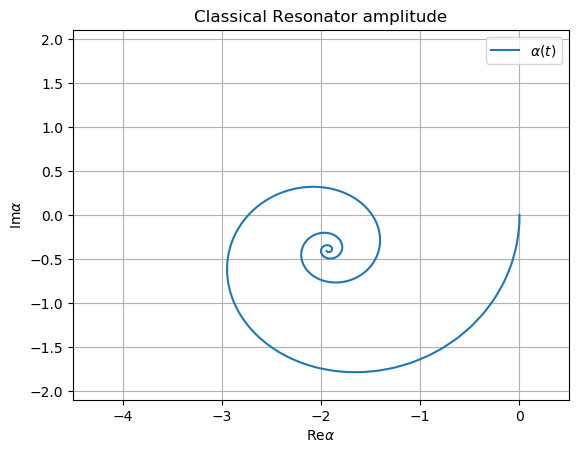

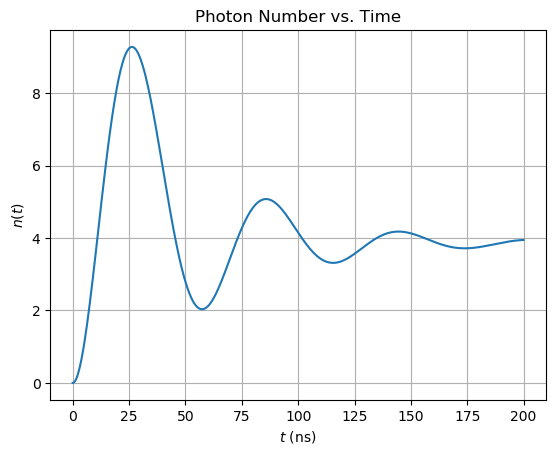

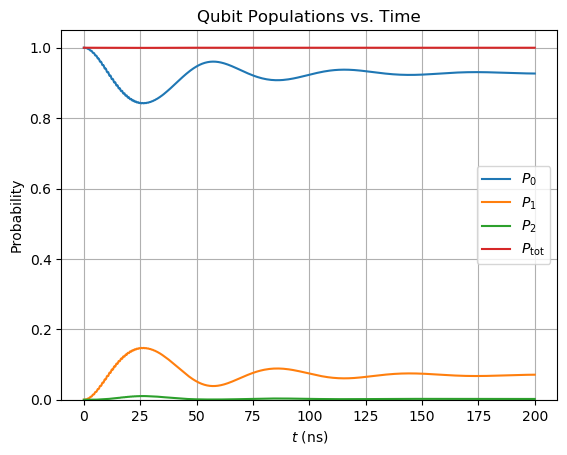

 66.425774 seconds (2.77 M allocations: 14.965 GiB, 2.50% gc time)


In [96]:
@time t = solveρ(lind)
plotsolution(t);